<a href="https://colab.research.google.com/github/paulohltc/MiniP1-PG/blob/master/monkeysClassifierTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# configurando kaggle e importando tudo
import os
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
kaggle_folder_name = 'kaggleDataset' #nome do seu folder do kaggle no colab
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks/'+kaggle_folder_name
%cd /content/drive/MyDrive/Colab Notebooks/"$kaggle_folder_name"
!ls #deve ter o kaggle.json

/content/drive/MyDrive/Colab Notebooks/kaggleDataset
kaggle.json  monkeyClassifier-phltc


In [ ]:
# 1 TIME ONLY
# baixando dataset no seu drive
!kaggle datasets download -d ansuld/10-monkey
!mkdir monkeyClassifier-phltc
!mv 10-monkey.zip monkeyClassifier-phltc
%cd monkeyClassifier-phltc/
!unzip 10-monkey.zip

In [ ]:
# 1 TIME ONLY
# mexendo no txt, se rodar mais de uma vez vai baguncar

# Vamos entender o dataset com o txt que veio junto

# O csv está muito mal formatado com espaços desnecessários,
# esse trecho do código foi justamente para limpar e usar (data munging)


labelstxt = 'monkey_labels.txt'
m = open(labelstxt,'r',encoding = 'utf8')
arr = m.readlines()
for i in range(len(arr)):
  arr[i] = arr[i].replace(' ','')
  arr[i] = arr[i].replace('\t','')
print(arr)
fixed_csv = ''.join(arr)
m.close()
m = open(labelstxt,'w',encoding = 'utf8')
m.write(fixed_csv)
m.close()

In [ ]:
# # caso rodou a celula de cima mais de uma vez e baguncou o txt 
# m = open(labelstxt,'w',encoding = 'utf8')
# fixedcsv = "Label,LatinName,CommonName,TrainImages,ValidationImages\nn0,alouatta_palliata,mantled_howler,131,26\nn1,erythrocebus_patas,patas_monkey,139,28\nn2,cacajao_calvus,bald_uakari,137,27\nn3,macaca_fuscata,japanese_macaque,152,30\nn4,cebuella_pygmea,pygmy_marmoset,131,26\nn5,cebus_capucinus,white_headed_capuchin,141,28\nn6,mico_argentatus,silvery_marmoset,132,26\nn7,saimiri_sciureus,common_squirrel_monkey,142,28\nn8,aotus_nigriceps,black_headed_night_monkey,133,27\nn9,trachypithecus_johnii,nilgiri_langur,132,26"
# m.write(fixedcsv)
# m.close()

In [ ]:
# garantindo que está no diretório certo
os.chdir('/content/drive/MyDrive/Colab Notebooks/'+kaggle_folder_name+'/monkeyClassifier-phltc/')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/kaggleDataset/monkeyClassifier-phltc'

In [ ]:
# depois de limpar
labelstxt = 'monkey_labels.txt'
labelsdf = pd.read_csv(labelstxt).set_index('Label')
labelsdf['TrainImages'] = labelsdf['TrainImages'].apply(lambda x: int(x))
labelsdf['ValidationImages'] = labelsdf['ValidationImages'].apply(lambda x: int(x))
print('Qtd imagens treino :',labelsdf['TrainImages'].sum())
print('Qtd imagens validacao :',labelsdf['ValidationImages'].sum())
labelsdf.head(10)

Qtd imagens treino : 1370
Qtd imagens validacao : 272


,LatinName,CommonName,TrainImages,ValidationImages
Label,,,,
n0,alouatta_palliata,mantled_howler,131,26
n1,erythrocebus_patas,patas_monkey,139,28
n2,cacajao_calvus,bald_uakari,137,27
n3,macaca_fuscata,japanese_macaque,152,30
n4,cebuella_pygmea,pygmy_marmoset,131,26
n5,cebus_capucinus,white_headed_capuchin,141,28
n6,mico_argentatus,silvery_marmoset,132,26
n7,saimiri_sciureus,common_squirrel_monkey,142,28
n8,aotus_nigriceps,black_headed_night_monkey,133,27


In [ ]:
# função de preprocessamento de uma imagem que usaremos bastante,
# lê uma imagem do dataset, converte , dá resize, e deixa em valores de 0 a 1
def preprocess_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [227, 227])
    img = tf.image.convert_image_dtype(img, tf.float32).numpy()/255.0
    return img

In [ ]:
# 1 TIME ONLY

from keras.preprocessing.image import ImageDataGenerator
#como o dataset não é muito grande, para nao termos overfitting 
#e até pra melhorarmos a accuracy, vamos usar o conceito de
#Data Augmentation, criando novas imagens a partir do nosso dataset
#estamos aumentando o tamanho do nosso dataset em 3x com isso
print(len(os.listdir('n0/')))
datagen = ImageDataGenerator(
    rotation_range = 35,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest")
def dataAug(image,label):
  image = image.reshape((1,) + image.shape) 
  i = 0
  for batch in datagen.flow(image,
                            save_to_dir = label,
                            save_prefix=label,
                            save_format='jpg'):
    i += 1
    if i > 4: 
      break 

labels = os.listdir() # n0 n1 n2 n3 ...
for label in labels:
  curr_folder = os.listdir(label+'/')
  for img_str in curr_folder:
    image = preprocess_img(label+'/'+img_str)
    dataAug(image,label) # Pra cada imagem do dataset original, foi feita uma ampliação de dados dela
  print(label,'ok')
print(len(os.listdir('n0/')))

105
n0 ok
n1 ok
n2 ok
n3 ok
n4 ok
n5 ok
n6 ok
n7 ok
n8 ok
n9 ok
607


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/'+kaggle_folder_name+'/monkeyClassifier-phltc/training/training')
labels = os.listdir() # n0 n1 n2 n3 ...
# fazendo o pré processamento do dataset, dando resize, colocando os pixeis entre 0 e 1
train_imgs = []
train_labels = []
# carregando todas as imagens do dataset e colocando na forma adequada
for label in labels: 
  curr_folder = os.listdir(label+'/')
  for img_str in curr_folder:
    img = preprocess_img(label+'/'+img_str)
    train_imgs.append(img)
    train_labels.append([int(label[1])])
  print(label ,'done')
train_imgs = np.array(train_imgs)
train_labels = np.array(train_labels)

n0 done
n1 done
n2 done
n3 done
n4 done
n5 done
n6 done
n7 done
n8 done
n9 done


In [ ]:
# iremos utilizar a indexacao escolhida pelo autor do dataset, e o nome comum como correspondente
def name(label):return labelsdf.loc['n'+str(label)]['CommonName'].title().replace('_',' ')
name(3)

'Japanese Macaque'

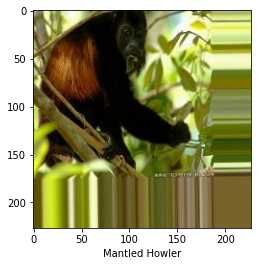

In [ ]:
# preview de uma imagem do dataset 
import random
n = random.randint(0,1000)
plt.imshow(train_imgs[n],cmap=plt.cm.prism)
plt.xlabel(name(train_labels[n][0]))
plt.show()

In [ ]:
inputShape = (227,227,3)
# Arquitetura AlexNet (1Conv->1Mp->1Conv->1Mp->3Conv->1Mp -> Parte artificial)
model = Sequential()
# 1a camada
model.add(Conv2D(filters = 96, input_shape=inputShape, kernel_size = (11, 11), strides = 4))
model.add(BatchNormalization(axis = 3)) # otimizador
model.add(Activation('relu'))
# Max pool
model.add(MaxPooling2D(pool_size = (3,3), strides = 2))
# 2a camada
model.add(Conv2D(filters = 256, kernel_size = (5, 5), strides = 1))
model.add(BatchNormalization(axis = 3)) # otimizador
model.add(Activation('relu'))
# Max pool
model.add(MaxPooling2D(pool_size = (3,3), strides = 2))
# 3a camada
model.add(Conv2D(filters = 384, kernel_size = (3, 3), strides = 1))
model.add(BatchNormalization(axis = 3)) # otimizador
model.add(Activation('relu'))
# 4a camada
model.add(Conv2D(filters = 384, kernel_size = (3, 3), strides = 1))
model.add(BatchNormalization(axis = 3)) # otimizador
model.add(Activation('relu'))
# 5a camada
model.add(Conv2D(filters = 256, kernel_size = (3, 3), strides = 1))
model.add(BatchNormalization(axis = 3)) # otimizador
model.add(Activation('relu'))
# Max pool
model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

# parte artificial
model.add(Flatten())
# 1a camada
model.add(Dense(4096,activation = 'relu'))
# adcionar Dropout
# metodo pra evitar Overfitting
model.add(Dropout(0.4))

# 2a  camada
model.add(Dense(4096,activation = 'relu'))
model.add(Dense(10,activation = 'softmax')) # 10 classes
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_15 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
activation_15 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 23, 23, 256)       614656    
_________________________________________________________________
batch_normalization_16 (Batc (None, 23, 23, 256)       1024      
_________________________________________________________________
activation_16 (Activation)   (None, 23, 23, 256)      

In [ ]:
#Compilacao e treinamento do modelo
EPOCHS = 20
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_imgs, train_labels,batch_size = 32,epochs=EPOCHS)

Epoch 1/20
201/201 [==============================] - 8s 37ms/step - loss: 2.9898 - accuracy: 0.2632
Epoch 2/20
201/201 [==============================] - 7s 37ms/step - loss: 1.5505 - accuracy: 0.4470
Epoch 3/20
201/201 [==============================] - 7s 36ms/step - loss: 1.3455 - accuracy: 0.5208
Epoch 4/20
201/201 [==============================] - 7s 37ms/step - loss: 1.1310 - accuracy: 0.6091
Epoch 5/20
201/201 [==============================] - 7s 37ms/step - loss: 1.0437 - accuracy: 0.6546
Epoch 6/20
201/201 [==============================] - 7s 37ms/step - loss: 0.9055 - accuracy: 0.6999
Epoch 7/20
201/201 [==============================] - 7s 36ms/step - loss: 0.7699 - accuracy: 0.7416
Epoch 8/20
201/201 [==============================] - 7s 37ms/step - loss: 0.7387 - accuracy: 0.7572
Epoch 9/20
201/201 [==============================] - 7s 37ms/step - loss: 0.6107 - accuracy: 0.8061
Epoch 10/20
201/201 [==============================] - 7s 37ms/step - loss: 0.5065 - accura

In [ ]:
%cd ..
%cd ..
%cd validation/validation

/content/drive/MyDrive/Colab Notebooks/kaggleDataset/monkeyClassifier-phltc/training
/content/drive/MyDrive/Colab Notebooks/kaggleDataset/monkeyClassifier-phltc
/content/drive/MyDrive/Colab Notebooks/kaggleDataset/monkeyClassifier-phltc/validation/validation


In [ ]:
img0 = preprocess_img('n6/'+os.listdir('n6/')[0])
img1 = preprocess_img('n1/'+os.listdir('n1/')[0])
img2 = preprocess_img('n3/'+os.listdir('n3/')[0])
img3 = preprocess_img('n3/'+os.listdir('n3/')[3])
x = model.predict(np.array([img0,img1,img2,img3]))
print(name(np.argmax(x[0])),np.argmax(x[0]))
print(name(np.argmax(x[1])),np.argmax(x[1]))
print(name(np.argmax(x[2])),np.argmax(x[2]))
print(name(np.argmax(x[3])),np.argmax(x[3]))

Silvery Marmoset 6
Patas Monkey 1
Japanese Macaque 3
Japanese Macaque 3


In [ ]:
#Exportando o modelo
%cd ..
%cd ..
if os.path.isfile('models/monkeyModel.h5') is False:
  model.save('monkeyModel.h5')

/content/drive/My Drive/Colab Notebooks/kaggleDataset/monkeyClassifier-phltc
/content/drive/My Drive/Colab Notebooks/kaggleDataset
/content/drive/My Drive/Colab Notebooks/kaggleDataset/models


In [ ]:
test_imgs = os.listdir('testando/')
test_imgs.sort()
test_labels = ['Silvery Marmoset','Japanese Macaque','Nilgiri Langur']
test_imgs

['monk1.jpg', 'monk2.jpg', 'monk3.jpg']

In [ ]:
testing = []
for img in test_imgs:
  testing.append(preprocess_img('testando/'+img))
testing = np.array(testing)
testing.shape

(3, 227, 227, 3)

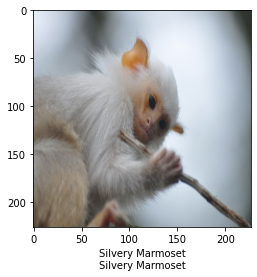

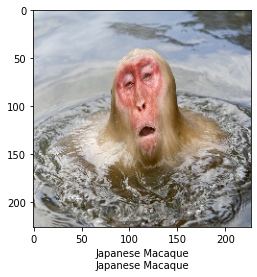

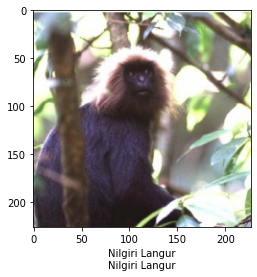

In [ ]:
predictions = model.predict(testing)
# o de cima é o que supos
# o de baixo o que realmente era
for i in range(3):
  plt.imshow(testing[i],cmap=plt.cm.prism)
  plt.xlabel(name(np.argmax(predictions[i])) + '\n' + test_labels[i])
  plt.show()